## Network analysis

### 1. Data preprocessing and visualization

In [1]:
import pandas as pd

# Import the data
application_events = pd.read_json('D:\\events\\applications.json')

# Print overview
application_events.head(3)

,appIdConsumer,appIdProvider,beatId,beatType,callId,callMode,callScope,correlationId,durationMs,eventTime,...,orgBezeichnung,orgId,orgKurzbezeichnung,orgSubkategorien,parentCallId,role,stage,tkNameIdConsumer,tkNameIdProvider,userId
0,spoud-app,sim-provider,0,ServiceProviderBeat,0,SYNC,LOCAL,6ee2fa2b-a1ca-405e-9088-94dbb834730f,201,2018-05-05T07:55:38.422185+00:00,...,Bellinzona,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU147400
1,spoud-app,sim-provider,2,ServiceProviderBeat,2,SYNC,LOCAL,7aa2e01f-4af6-48e8-ae98-a42fe9fc6e5d,201,2018-05-05T07:55:38.432086+00:00,...,Lyss,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU534284
2,spoud-app,sim-provider,4,ServiceProviderBeat,4,SYNC,LOCAL,f722a638-7e0d-4f19-86ad-7aeecbffa40f,201,2018-05-05T07:55:38.441987+00:00,...,Winterthur,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU816207


In [2]:
# Print some initial statistics
application_events.describe()

,beatId,callId,durationMs,meta_linecount,meta_version
count,1.296000e+06,1.296000e+06,1.296000e+06,1296000.0,1.296000e+06
mean,1.799000e+03,1.169906e+02,3.598675e+02,1.0,1.000000e-01
std,1.039231e+03,8.128626e+01,1.350601e+02,0.0,2.357893e-12
min,0.000000e+00,0.000000e+00,2.000000e+02,1.0,1.000000e-01
25%,8.995000e+02,4.950000e+01,2.690000e+02,1.0,1.000000e-01
50%,1.799000e+03,1.020000e+02,3.400000e+02,1.0,1.000000e-01
75%,2.698500e+03,1.760000e+02,4.250000e+02,1.0,1.000000e-01
max,3.598000e+03,3.180000e+02,1.955000e+03,1.0,1.000000e-01


In [3]:
# Check for missing values
null_values = application_events.isnull().sum()
print('Number of None/NaN\'s: %s' % null_values[null_values != 0].count())

Number of None/NaN's: 0


##### Worktime calculation

$$\large w_t = \bar{r}_n * n_c $$

(Possible inconsistend description in challenge. Sum of response time or number of requests times average response time)

($ w_t $ = worktime,
$ r_t $ = response time,
$ n_c $ = throughput / number of service calls)


In [4]:
# Overview of involved components
tk_field, event_time_field, duration_field = 'tkNameIdProvider', 'eventTime', 'durationMs'
id_fields = ['appIdProvider', 'fkNameProvider', tk_field]
unique_components = zip([id_field for id_field in id_fields], 
                        ['Application', 'Functional component', 'Technical component'])
for field, name in unique_components:
    unique_components = application_events[field].unique()
    print('%d %s\'s:' % (unique_components.size, name), end=' ')
    print(', '.join(str(c) for c in unique_components))

1 Application's: sim-provider
1 Functional component's: fkNameProvider
18 Technical component's: tm4-Mond-52, tm4-Phobos-52, tm4-Deimos-52, tm4-Adrastea-52, tm4-Metis-52, tm4-Amalthea-52, tm4-Thebe-52, tm4-Io-52, tm4-Europa-52, tm4-Ganymed-52, tm4-Kallisto-52, tm4-Themisto-52, tm4-Leda-52, tm4-Himalaia-52, tm4-Lysithea-52, tm4-Elara-52, tm4-Carpo-52, tm4-Euporie-52


In [5]:
# Create dataset with one minute buckets and only relevant information
performance = application_events[[tk_field, duration_field, event_time_field]]
performance = performance.set_index(event_time_field)
performance.index = pd.to_datetime(performance.index)

In [8]:
# Inspect time frame
start, end, duration = performance.index.min(), performance.index.max(), performance.index.max() - performance.index.min() 
print('Time frame: %s to %s (%s)' % (start.strftime("%Y-%m-%d %H:%M:%S"), end.strftime("%Y-%m-%d %H:%M:%S"), duration))

Time frame: 2018-05-05 07:55:38 to 2018-05-05 19:54:39 (0 days 11:59:00.993711)


In [ ]:
# Group the data into one minutes bin grouped by technical component
#performance_bins = performance.groupby(tk_field).resample('1T').sum() \
#    .reset_index() \
#    .pivot(index='eventTime', columns='tkNameIdProvider', values='durationMs')

In [9]:
# Build a dicitionary with all components
all_components = {}

# Method for building statistics for group
def aggregate_stats(group):
    number_of_requests = group_component.count()
    total_duration = group_component.sum()
    avg_response_time = total_duration / number_of_requests
    # (Alternate definition in document: worktime = avg_response_time * number_of_requests)
    performance_of_component = pd.DataFrame({'component_name': technical_component,  
                                             'worktime' : total_duration, 
                                             'throughput' : number_of_requests, 
                                             'response_time' : avg_response_time})
    return performance_of_component

for technical_component in performance[tk_field].unique():       
    group_component = performance.loc[performance[tk_field] == technical_component] \
        .resample('1T')[duration_field]
    all_components[technical_component] = aggregate_stats(group_component)

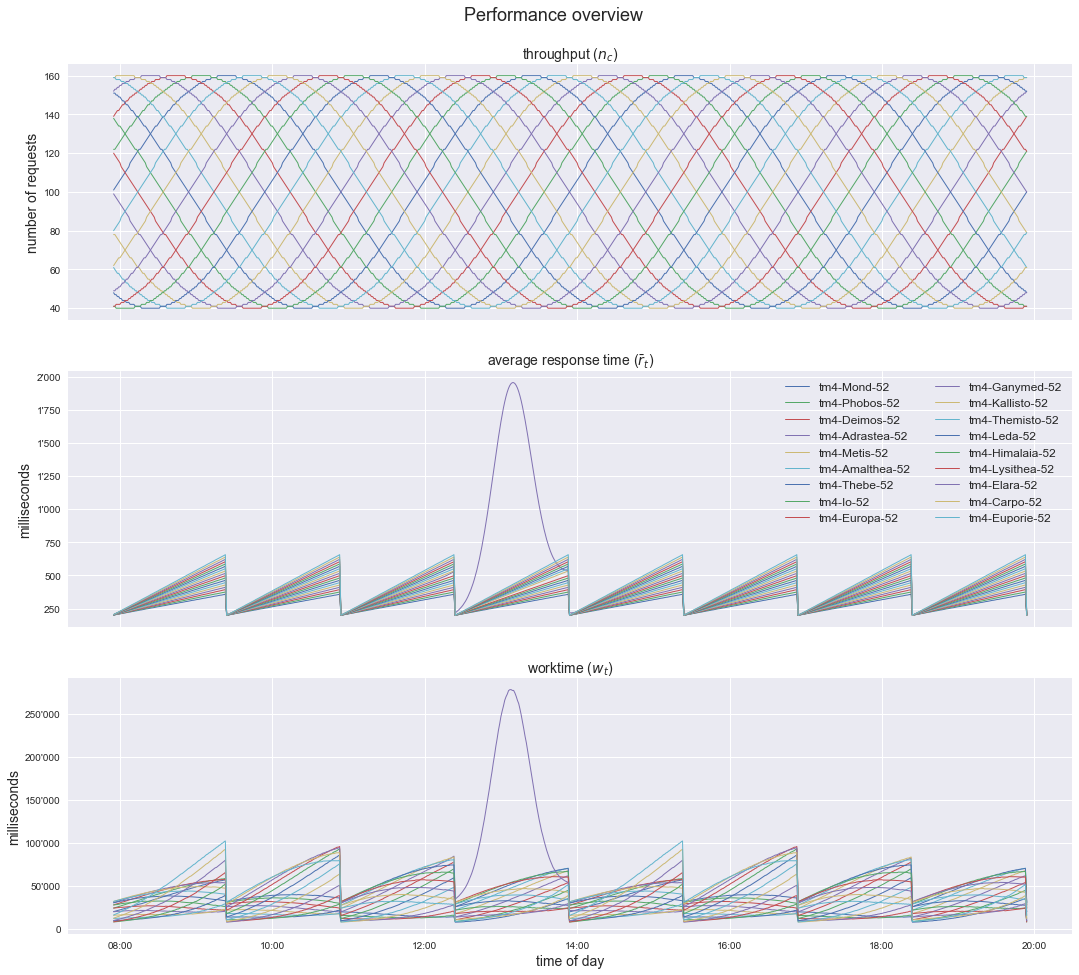

In [83]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale
import numpy as np

# Set searborn style for plot
plt.style.use('seaborn')

# Plot metrics for comparision
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18,16))
plt.suptitle('Performance overview', fontsize=18, y=.93, fontweight='bold')
locale.setlocale(locale.LC_ALL, 'de-CH')
thousand_formatter = plt.FuncFormatter(lambda x, _ : locale.format("%d", x, grouping=True))
for component in all_components.values():
    
    ax1.plot(component['throughput'], linewidth=1)
    ax1.set_title('throughput ($ n_c $)', fontsize=14)
    ax1.set_ylabel('number of requests', fontsize=14)
    
    ax2.plot(component['response_time'], linewidth=1)
    ax2.set_title('average response time ($ \\bar{r}_t $)', fontsize=14)
    ax2.yaxis.set_major_formatter(thousand_formatter)
    ax2.set_ylabel('milliseconds', fontsize=14)
    
    ax3.plot(component['worktime'], linewidth=1)
    ax3.set_title('worktime ($ w_t $)', fontsize=14)
    ax3.set_ylabel('milliseconds', fontsize=14)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))    
    ax3.yaxis.set_major_formatter(thousand_formatter)
    ax3.set_xlabel('time of day', fontsize=14)

ax2.legend(all_components.keys(), ncol=2, prop={'size': 12})
plt.show()

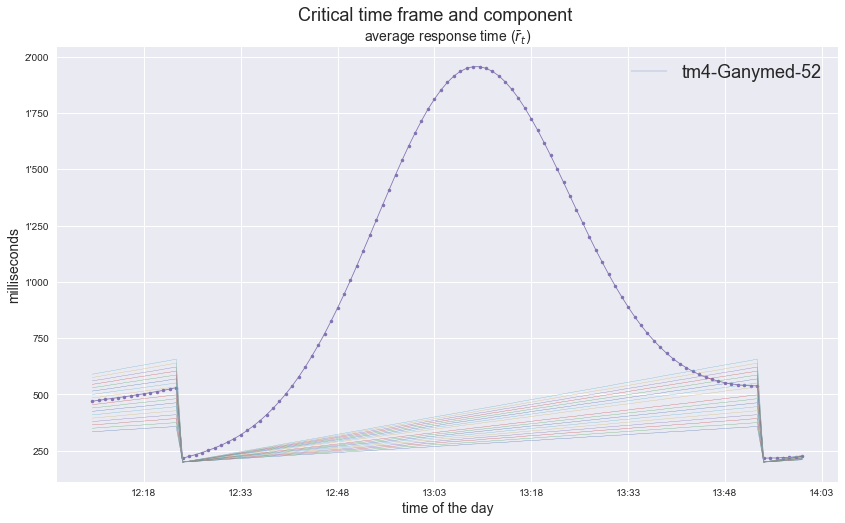

In [118]:
# Have a closer look at the critical time
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(14,8))
plt.suptitle('Critical time frame and component', fontsize=18, y=.95)
for name, component in all_components.items():
    
    ax.plot(component['2018-05-05 12:10:00':'2018-05-05 14:00:00']['response_time'], 
            '.-' if name == 'tm4-Ganymed-52' else '-',
            linewidth=.8 if name == 'tm4-Ganymed-52' else .3)
    ax.set_title('average response time ($ \\bar{r}_t $)', fontsize=14)
    ax.yaxis.set_major_formatter(thousand_formatter)
    ax.set_ylabel('milliseconds', fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))    
    ax.yaxis.set_major_formatter(thousand_formatter)
    ax.set_xlabel('time of the day', fontsize=14)

ax.legend(['tm4-Ganymed-52'], ncol=2, prop={'size': 18})
plt.show()

### 2. Time series forecasting

In [17]:
# Choose component for forecasting
chosen_component_id = 'tm4-Himalaia-52'

In [18]:
chosen_component = all_components[chosen_component_id]
chosen_component.head()

,component_name,response_time,throughput,worktime
eventTime,,,,
2018-05-05 07:55:00,tm4-Himalaia-52,204.0,41,8364
2018-05-05 07:56:00,tm4-Himalaia-52,208.0,41,8528
2018-05-05 07:57:00,tm4-Himalaia-52,213.0,40,8520
2018-05-05 07:58:00,tm4-Himalaia-52,217.0,40,8680
2018-05-05 07:59:00,tm4-Himalaia-52,221.0,40,8840


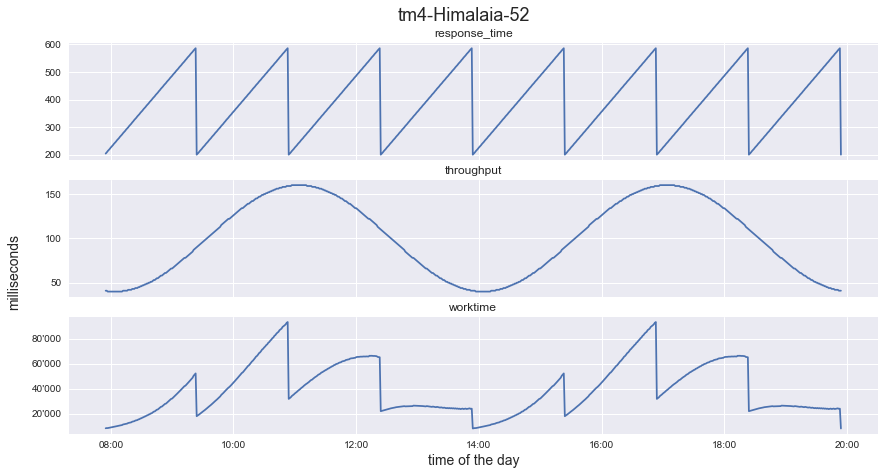

In [132]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 6))

plt.tight_layout()
plt.suptitle('tm4-Himalaia-52', fontsize=18, y=1.05)
for axis, feature in zip(axes, ['response_time', 'throughput', 'worktime']):
    axis.plot(chosen_component[feature]) 
    axis.set_title(feature)
    axis.yaxis.set_major_formatter(thousand_formatter)
    
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))    
axes[2].set_xlabel('time of the day', fontsize=14)
fig.text(-.02, .5, 'milliseconds', ha='center', rotation='vertical', fontsize=14)
plt.show()

Because there is a linear increase in respone time a multiplicative model for decomposition has been chosen. 

### 2.1 Average response time

#### 2.1.1 Seasonal decomposition of average response time

In [22]:
def plot_correlation(data):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
    plot_acf(data, alpha=.05, lags=(2*60), ax=ax1)
    plot_pacf(data, alpha=.05, lags=(2*60), ax=ax2)
    plt.show()
    print('Autocorrelation is: %4.2f' % data.autocorr())

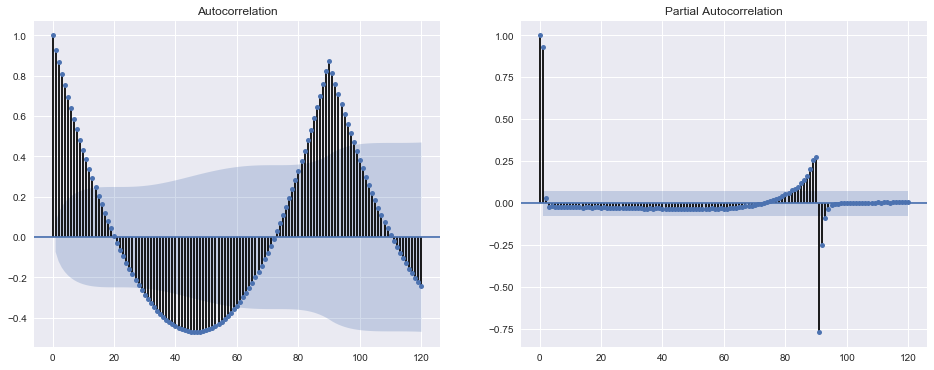

Autocorrelation is: 0.93


In [633]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

response_times = chosen_component['response_time']

# Examine autocorrelation and partial autocorrelation of the response times
plot_correlation(response_times)

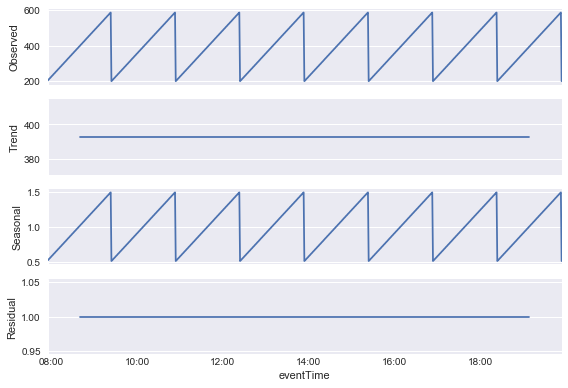

In [248]:
import statsmodels.api as sm

# Plot the decomposition of the time series
response_time_components = sm.tsa.seasonal_decompose(chosen_component['response_time'], model='multiplicative', freq=90)
response_time_components.plot()
plt.show()

There is only seasonality and no trend and noise in the (obviously artifically created) data.

#### 2.1.2 Generating a forecast for response time

Straightforward would be to learn paramaters for an ARMA (auto regressive moving average) model

In [30]:
from datetime import timedelta 

# Because the data is artifical we choose 60/40 split 
def train_test_split(data, percentage=.6):
    split_minute = data.index[0] + timedelta(minutes=(12 * 60) * percentage)
    train_data = data[:split_minute]
    test_data = data.iloc[train_data.count():]
    print("Training data: %s rows" % train_data.count())
    print("Testing data: %s rows" % test_data.count())
    return (train_data, test_data)

In [663]:
train_data, test_data = train_test_split(response_times)

Training data: 433 rows
Testing data: 287 rows


In [711]:
import itertools
import warnings

# Function for grid search over seasonal parameters of a SARIMAX model
def sarimax_grid_search(data, seasonality_lag, plot_progress = False):
    
    # Because not all parameter of a grid search work, we disable warnings
    warnings.filterwarnings('ignore')

    max_param = 2
    p=d=q = range(0, max_param)

    bic = {}
    aic = {}

    # Initialize cartesian product for seasonal parameters (with fix lag for seasonality)
    seasonal_pdq = [(x[0], x[1], x[2], seasonality_lag) for x in list(itertools.product(p, d, q))]
    
    # Performing a grid search over the different parameters evaluate their information criterias
    for seasonal_model in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=(0,0,0),
                                            seasonal_order=seasonal_model,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            result = mod.fit()
            if plot_progress:
                print('SARIMAX %sx%s' % ('(0, 0, 0)', (seasonal_model)), end=' ')
                print('-- AKAIKE: %s, BIC: %s' % (result.aic, result.bic))
            key = '%sx%s' % ('(0, 0, 0)', (seasonal_model))
            bic[key] = result.bic
            aic[key] = result.aic
        except:
            continue
                
    warnings.filterwarnings('default')
    
    best_model = min(aic, key=aic.get)
    return (bic, aic, best_model)

In [685]:
# Perform grid search and get best model
bic, aic, best_model = sarimax_grid_search(train_data, 90)

We choose the AKAIKE information criterion as performance measurement because it punishes additonal parameters.

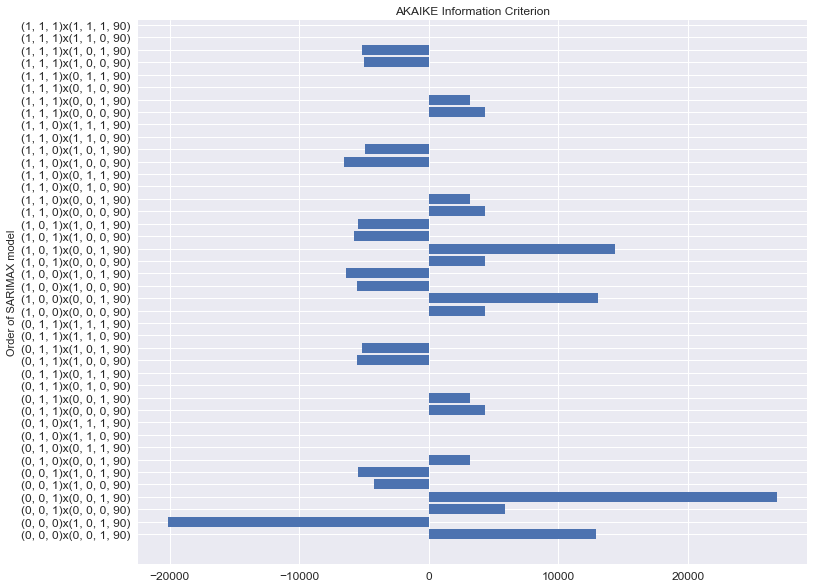

In [614]:
# Print different models with their akaike information criterion
fit, ax1 = plt.subplots(1, sharex=True, figsize=(12,10))

ax1.tick_params(labelsize=12)
ax1.barh(range(len(aic.keys())), aic.values(), 
        tick_label=aic.keys())
ax1.set_title('AKAIKE Information Criterion')
ax1.set_ylabel('Order of SARIMAX model')

plt.show()

In [575]:
# Print performance of model with lowest information criteria
print("Performance Model %s: %s (BIC) / %s (AKAIKE)" % (best_model,
      bic[best_model], aic[best_model]))

Performance Model (0, 0, 0)x(1, 0, 1, 90): -20125.0015676 (BIC) / -20137.2137808 (AKAIKE)


The best model is a SARIMAX (Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors) of order (0, 0, 0)x(1, 0, 1, 90). This makes sense, because there are no residuals in our model and it can be explained by the seasonal components only

In [720]:
# Function for fitting an sarimax model
def fit_arimax_model(data, order, seasonal_order):
    
    warnings.filterwarnings('ignore')

    results = None

    # We fit the model with our parameters from the grid search
    mod = sm.tsa.statespace.SARIMAX(data,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()

    warnings.filterwarnings('default')
    
    return results

In [ ]:
# Fitting the best performaing model
results = fit_arimax_model((0, 0, 0), (1, 0, 1, 90)) 

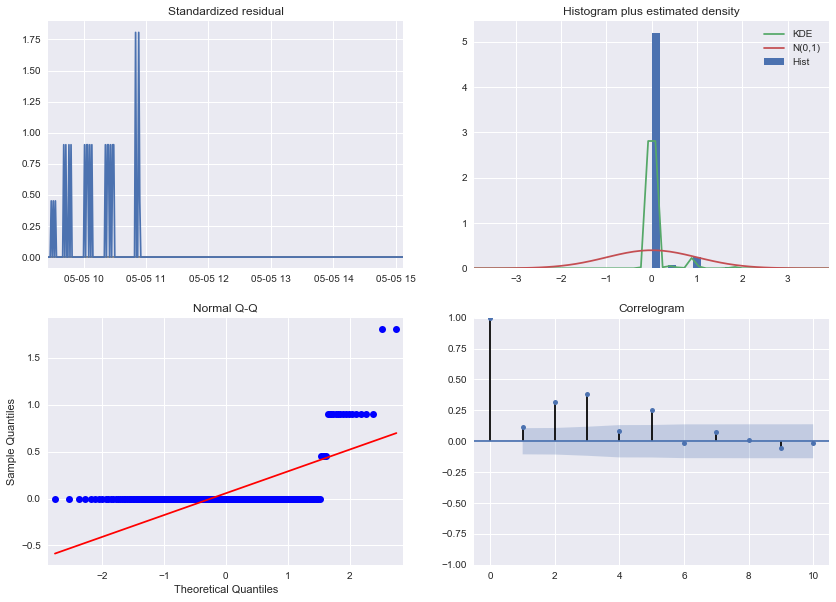

In [621]:
# Print some diagnostics for the residuals (not of much help, because we lack residuals)
results.plot_diagnostics(figsize=(14, 10))

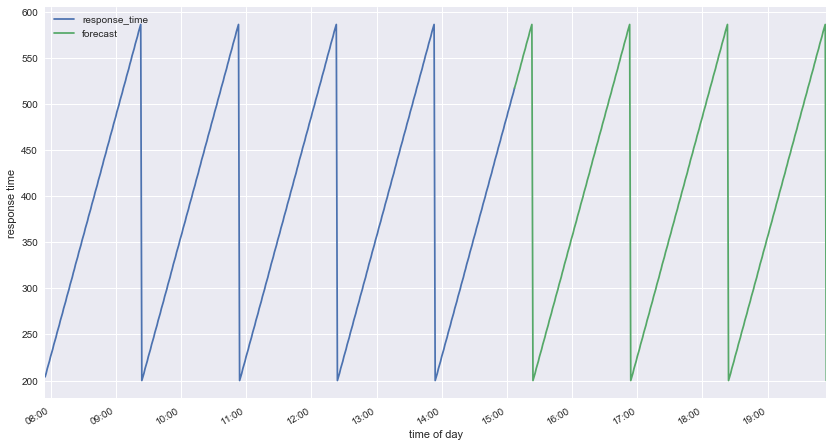

In [616]:
# Performing a one step ahead forecast
pred = results.get_prediction(start='2018-05-05 15:07:00', end='2018-05-05 19:54:00', dynamic=False)
conf_int = pred.conf_int()

fig, ax = plt.subplots(1, 1, figsize=(14,8))

ax.plot(train_data)
pred.predicted_mean.plot(ax=ax, label='forecast')
ax.set_ylabel('response time')
ax.set_xlabel('time of day')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.legend()
plt.show()

In [768]:
def calculate_mse(actual, predicted):
    mse = ((actual - predicted) ** 2).mean()
    print('The MSE of our forecast is %s' % mse)

In [617]:
# Calculate the mean squred error of our predition
calculate_mse(pred.predicted_mean, test_data)

The MSE of our forecast is 0.0


### 2.2 Throughput (number of requests)

#### 2.2.1 Seasonal decomposition of throughput

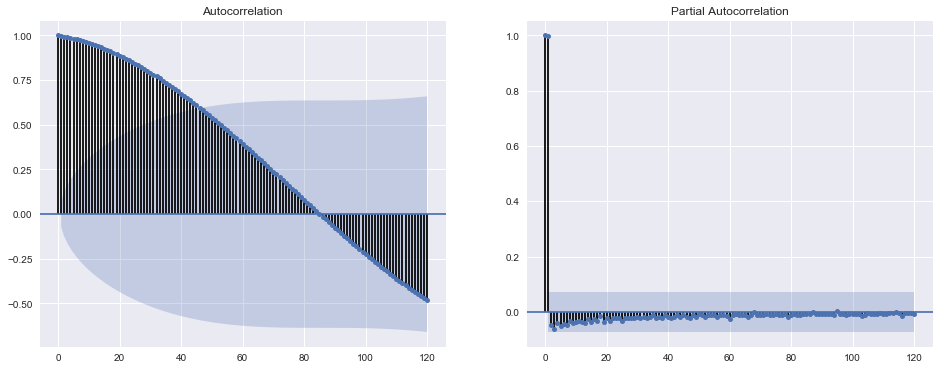

Autocorrelation is: 1.00


In [635]:
throughput = chosen_component['throughput']

# Examine autocorrelation and partial autocorrelation of the throughput
plot_correlation(throughput)

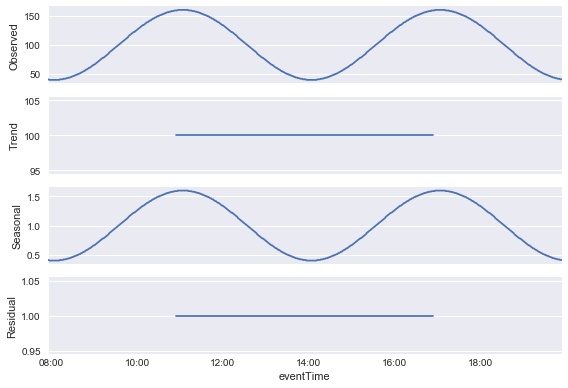

In [664]:
# Plot the decomposition of the throughput
throughput_components = sm.tsa.seasonal_decompose(throughput, model='multiplicative', freq=360)
throughput_components.plot()
plt.show()

Same as above, there is only a seasonal variation in the data

#### 2.2.2 Forecast of throughput

In [800]:
troughput_resampled = throughput.resample('10T').sum()['2018-05-05 08:00:00':'2018-05-05 19:40:00']

In [810]:
# Performing split for throughput
train_data, test_data = train_test_split(troughput_resampled, .9)

Training data: 65 rows
Testing data: 6 rows


In [811]:
# Grid search over parameters for sarimax model
bic, aic, best_model = sarimax_grid_search(train_data, 36)
print('Best SARIMAX model: %s' % best_model)

Best SARIMAX model: (0, 0, 0)x(1, 0, 0, 36)


In [806]:
# Fitting the best performaing model
results = fit_arimax_model(train_data, (0,0,0), ((1, 0, 0, 36)))

In [868]:
def make_prediction(data, fitted_model):
    pred = fitted_model.get_prediction(start='2018-05-05 18:40:00', end='2018-05-05 23:59:00', dynamic=False)
    fig, ax = plt.subplots(1, 1, figsize=(12,8))
    ax.plot(data)
    pred.predicted_mean.plot(ax=ax, label='forecast')
    ax.set_ylabel('response time')
    ax.set_xlabel('time of day')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.yaxis.set_major_formatter(thousand_formatter)
    ax.axvline('2018-05-05 18:40:00', linewidth=1, alpha=.7, linestyle=':')
    ax.axvline('2018-05-05 19:40:00', linewidth=1, alpha=.7, linestyle=':')
    plt.legend()
    plt.show() 

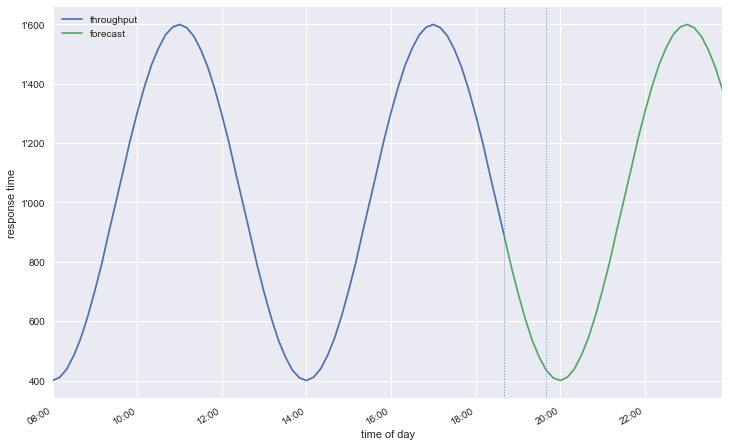

In [861]:
# Performing a one step ahead forecast
make_prediction(train_data, results)

In [822]:
# Calculate the mean squred error of our predition for the test set
pred = results.get_prediction(start='2018-05-05 18:40:00', end='2018-05-05 19:40:00', dynamic=False)

calculate_mse(pred.predicted_mean, test_data)

The MSE of our forecast is 2.8542039365436504e-26


So we have a minimal MSE probably because of our resamping process

### 2.3 Worktime

#### 2.3.1 Seasonal decomposition of worktime

In [21]:
worktime = chosen_component['worktime']

# Examine autocorrelation and partial autocorrelation of the worktime
plot_correlation(worktime)

NameError: name 'plot_correlation' is not defined

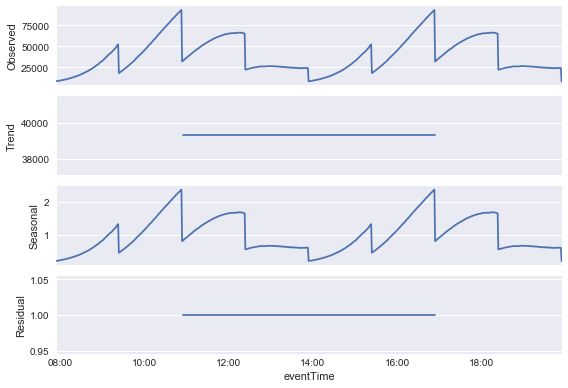

In [824]:
# Plot the decomposition of the throughput
worktime_components = sm.tsa.seasonal_decompose(worktime, model='multiplicative', freq=360)
worktime_components.plot()
plt.show()

#### 2.3.2 Forecast of worktime

Because worktime is a function of throughput and response time the seasonality corresponds with the longer season of throughput and we have 360 lags as well. 

In [864]:
# We apply same resampling procedure as above
worktime_resampled = worktime.resample('10T').sum()['2018-05-05 08:00:00':'2018-05-05 19:40:00']

# Performing split for throughput
train_data, test_data = train_test_split(worktime_resampled, .9)

Training data: 65 rows
Testing data: 6 rows


In [867]:
# Grid search over parameters for sarimax model
bic, aic, best_model = sarimax_grid_search(train_data, 36)
print('Best SARIMAX model: %s' % best_model)

Best SARIMAX model: (0, 0, 0)x(1, 0, 0, 36)


As expected same best model as for throughput with same seasonality.

In [870]:
# Fitting the best performaing model
results = fit_arimax_model(train_data, (0,0,0), ((1, 0, 0, 36)))

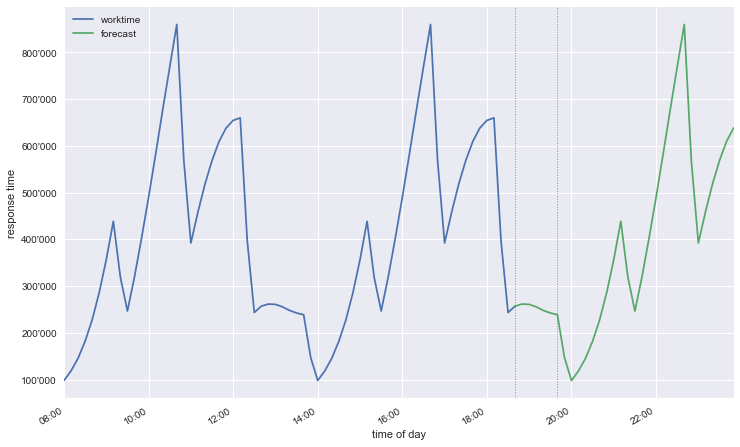

In [871]:
# Performing a one step ahead forecast
make_prediction(train_data, results)

In [872]:
# Calculate the mean squred error of our predition for the test set
pred = results.get_prediction(start='2018-05-05 18:40:00', end='2018-05-05 19:40:00', dynamic=False)

calculate_mse(pred.predicted_mean, test_data)

The MSE of our forecast is 2.541098841762901e-21


#### 2.3.3 Variation: Forecast of worktime with an LSTM

In this not requested step I try to build a model with a long short-term memory network (LSTM) with keras and tensorflow.

In [12]:
import numpy as np

# We fix seed for reproducability
np.random.seed(42)

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [35]:
# We also split our data into train and test 
train_data, test_data = train_test_split(worktime)

Training data: 433 rows
Testing data: 287 rows


In [75]:
# Normalize features
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_values = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_serie = pd.DataFrame(scaled_values)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [76]:
window_size = 5

series_copy = scaled_serie.copy()
for i in range(window_size):
    scaled_serie = pd.concat([scaled_serie, series_copy.shift(-(i+1))], axis = 1)
    
scaled_serie.dropna(axis=0, inplace=True)

In [85]:
scaled_serie.iloc[:, 0:4]

,0,0,0,0
0,-0.996140,-0.992280,-0.992468,-0.988702
1,-0.992280,-0.992468,-0.988702,-0.984937
2,-0.992468,-0.988702,-0.984937,-0.980229
3,-0.988702,-0.984937,-0.980229,-0.976463
4,-0.984937,-0.980229,-0.976463,-0.972698
5,-0.980229,-0.976463,-0.972698,-0.967990
6,-0.976463,-0.972698,-0.967990,-0.964224
7,-0.972698,-0.967990,-0.964224,-0.960458
8,-0.967990,-0.964224,-0.960458,-0.955751
9,-0.964224,-0.960458,-0.955751,-0.951985


In [107]:

model = Sequential()
model.add(LSTM(4, input_shape=(4, 1), return_sequences=True))
model.add(LSTM(1, return_sequences=True))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 4, 4)              96        
_________________________________________________________________
lstm_15 (LSTM)               (None, 4, 1)              24        
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
scaled_serie.values

array([[-0.99614   , -0.99227999, -0.99246828, -0.98870243, -0.98493657,
        -0.98022925],
       [-0.99227999, -0.99246828, -0.98870243, -0.98493657, -0.98022925,
        -0.97646339],
       [-0.99246828, -0.98870243, -0.98493657, -0.98022925, -0.97646339,
        -0.97269753],
       ..., 
       [-0.43803987, -0.41871631, -0.40075788, -0.38261115, -0.36262857,
        -0.34408172],
       [-0.41871631, -0.40075788, -0.38261115, -0.36262857, -0.34408172,
        -0.32534658],
       [-0.40075788, -0.38261115, -0.36262857, -0.34408172, -0.32534658,
        -0.30470497]])

In [108]:
model.fit(scaled_serie.iloc[:, 0:4], scaled_serie.iloc[:, 4].values, epochs=100, batch_size=1, verbose=2)

ValueError: Error when checking input: expected lstm_14_input to have 3 dimensions, but got array with shape (428, 4)

In [55]:
# First we define a new dataset with the previous values in the sequence
t_0 = train_data.values[:-1]
t_1 = train_data.values[1:]
t_2 = train_data.values[2:]
X_train = np.column_stack((t_0, t_1))
np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

array([[[ 8364,  8528]],

       [[ 8528,  8520]],

       [[ 8520,  8680]],

       [[ 8680,  8840]],

       [[ 8840,  9040]],

       [[ 9040,  9200]],

       [[ 9200,  9360]],

       [[ 9360,  9560]],

       [[ 9560,  9720]],

       [[ 9720,  9880]],

       [[ 9880, 10080]],

       [[10080, 10240]],

       [[10240, 10400]],

       [[10400, 10600]],

       [[10600, 10760]],

       [[10760, 10920]],

       [[10920, 11398]],

       [[11398, 11562]],

       [[11562, 11726]],

       [[11726, 11931]],

       [[11931, 12095]],

       [[12095, 12558]],

       [[12558, 12768]],

       [[12768, 12936]],

       [[12936, 13104]],

       [[13104, 13631]],

       [[13631, 13803]],

       [[13803, 14018]],

       [[14018, 14520]],

       [[14520, 14696]],

       [[14696, 14916]],

       [[14916, 15435]],

       [[15435, 15615]],

       [[15615, 16192]],

       [[16192, 16376]],

       [[16376, 16920]],

       [[16920, 17155]],

       [[17155, 17712]],

       [[177

In [ ]:


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, trainY, epochs=100, batch_size=1, verbose=2)all_layers_resampled['worktime-app']

### 3. Correlating the layers

I see two obvious methods for finding the event sequence:
* Examine the time of the event correlated by correlation id (does not fullfill the plot)
* Plot all three layers together and examine patterns (which would not incorporate a common key as demanded)

Problem is:
* Bucketing removes correlation and why correlation across key if we have the time of the layers

In [106]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale
import numpy as np
import pandas as pd

# Set searborn style for plot
plt.style.use('seaborn')

In [2]:
# We filter application events and select relevant columns
chosen_component_id = 'tm4-Himalaia-52'
application_events = pd.read_json('D:\\events\\applications.json')
application_events = application_events[application_events['tkNameIdProvider'] == chosen_component_id]

application_events = application_events.rename(columns={
    'callId': 'callId-app','correlationId': 'corrID','eventTime': 'logTime-app'})

In [3]:
# Import the data from the web entry server
wes_events = pd.read_json('D:\\events\\wes.json')
wes_events = wes_events.rename(columns={'callId': 'callId-wes','logTime': 'logTime-wes'})

In [4]:
# Import the data from the apache web server
apache_events = pd.read_json('D:\\events\\apache.json')
apache_events = apache_events.rename(columns={'callId': 'callId-apache', 'logTime': 'logTime-apache'})

In [5]:
# Joining all three layers together with correlation id
application_and_wes = pd.merge(application_events, wes_events, on='corrID', how='inner')
all_layers = pd.merge(application_and_wes, apache_events, on='corrID', how='inner')

all_layers.index = all_layers['logTime-app']
all_layers.index = pd.to_datetime(all_layers.index)

In [6]:
all_layers[['logTime-app', 'logTime-wes', 'logTime-apache']].head() 

,logTime-app,logTime-wes,logTime-apache
logTime-app,,,
2018-05-05 07:55:38.436674,2018-05-05T07:55:38.436674+00:00,2018-05-05T07:55:38.446674+00:00,2018-05-05T07:55:38.466674+00:00
2018-05-05 07:55:38.461064,2018-05-05T07:55:38.461064+00:00,2018-05-05T07:55:38.471064+00:00,2018-05-05T07:55:38.491064+00:00
2018-05-05 07:55:38.485455,2018-05-05T07:55:38.485455+00:00,2018-05-05T07:55:38.495455+00:00,2018-05-05T07:55:38.515455+00:00
2018-05-05 07:55:38.509845,2018-05-05T07:55:38.509845+00:00,2018-05-05T07:55:38.519845+00:00,2018-05-05T07:55:38.539845+00:00
2018-05-05 07:55:38.534235,2018-05-05T07:55:38.534235+00:00,2018-05-05T07:55:38.544235+00:00,2018-05-05T07:55:38.564235+00:00


Log times are suggesting following order of events for tm4-Himalaia-52: _application > wes > apache_

In [8]:
all_layers[['callId-app','callId-wes','callId-apache']].head()

,callId-app,callId-wes,callId-apache
logTime-app,,,
2018-05-05 07:55:38.436674,0,1,2
2018-05-05 07:55:38.461064,2,3,4
2018-05-05 07:55:38.485455,4,5,6
2018-05-05 07:55:38.509845,6,7,8
2018-05-05 07:55:38.534235,8,9,10


Call order does suggest same order of layers.

In [48]:
# Calculate worktime for all components (with formula for average)
all_layers_resampled = all_layers.resample('1T')
number_of_requests = all_layers_resampled['corrID'].count()
worktime_app = all_layers_resampled['durationMs'].mean() * number_of_requests
worktime_wes = all_layers_resampled['dTF'].mean() * number_of_requests
worktime_apache = (all_layers_resampled['time'].mean() / 1000) * number_of_requests

In [52]:
worktime_all_layers = pd.DataFrame({'worktime-app': worktime_app,
                          'worktime-wes': worktime_wes,
                          'worktime-apache':worktime_apache})

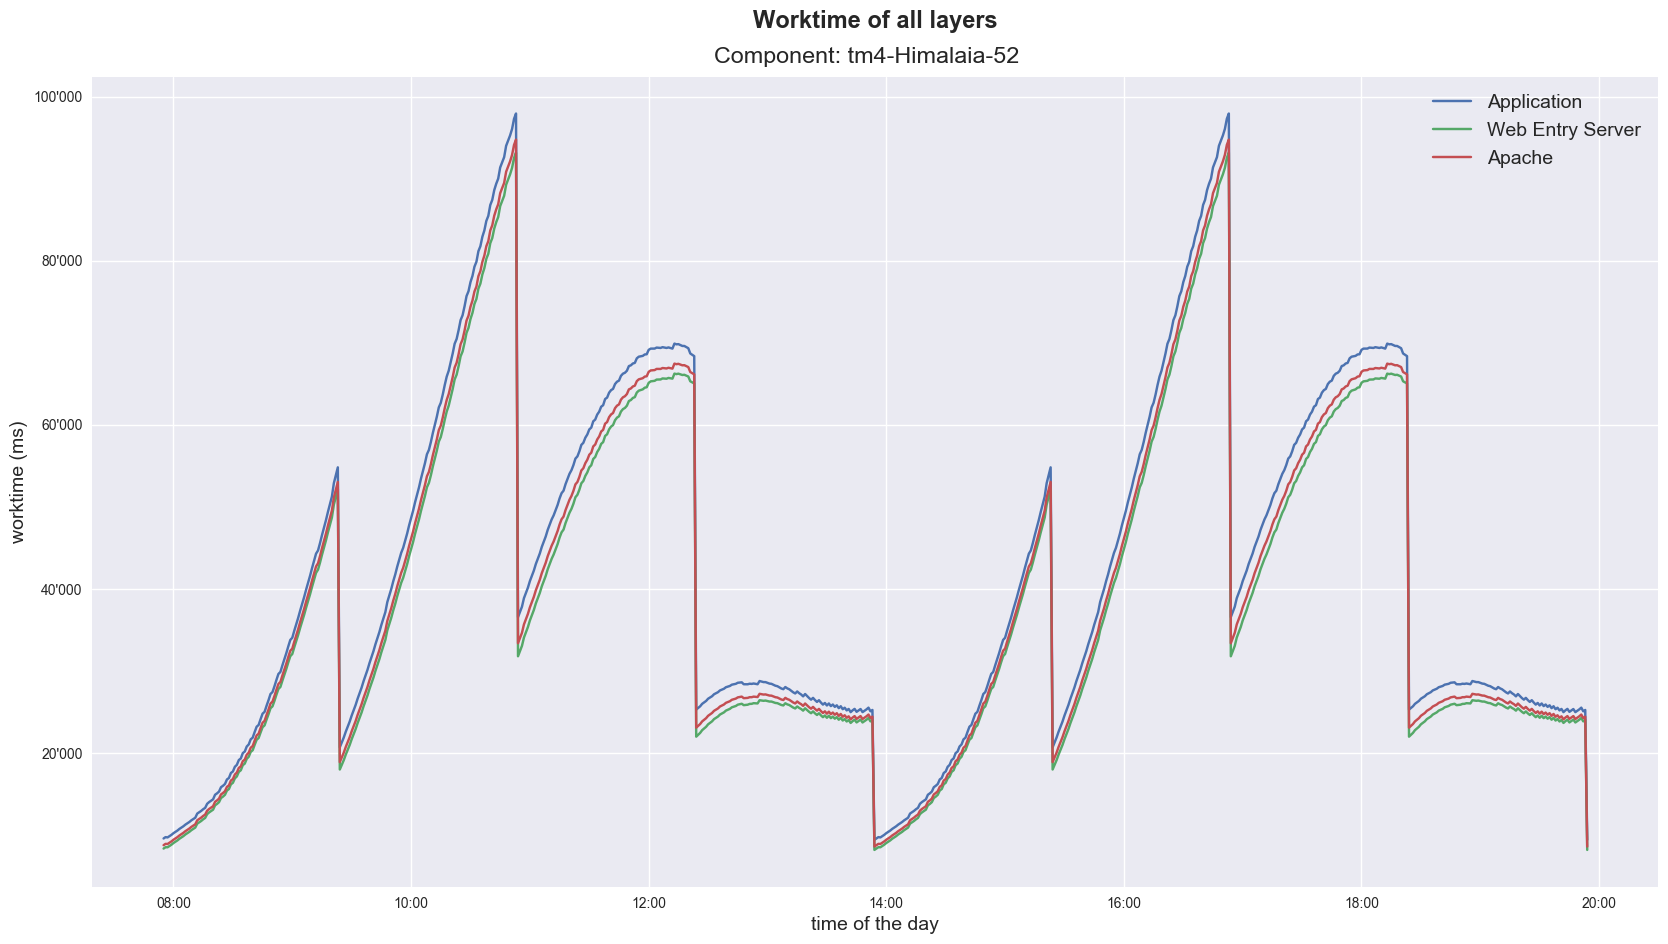

In [107]:
# Plot worktime of all layers in one graph
fig, ax = plt.subplots(1,1, figsize=(18,10))

plt.suptitle('Component: ' + chosen_component_id, y=.91, x=.51)
ax.plot(worktime_all_layers)
ax.set_title('Worktime of all layers', fontsize=17, fontweight='bold', y=1.05)
ax.set_ylabel('worktime (ms)', fontsize=14)
ax.set_xlabel('time of the day', fontsize=14)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(thousand_formatter)
ax.legend(['Application', 'Web Entry Server', 'Apache'], fontsize=14)

plt.show()